[complexity]:  44177.556687196615
[pareto set]:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 20


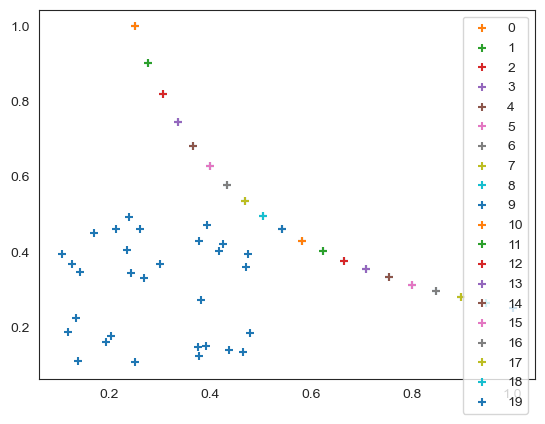

In [1]:
# coding=utf-8
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import uniform
from main import load
from lib.bandits import Bernoulli, Gaussian
from lib.policies import (py_ege_sr, py_ege_sh,
                          py_ape_fb, py_ua,
                          py_psi_ucbe, py_psi_ucbe_adapt,
                          py_ape_b, py_ape_b_adapt,
                          py_batch_ua, py_batch_sr,
                          py_batch_sh, py_batch_ape,
                          py_batch_ape_adapt)
sns.set_style("white")
#K = 20
#D = 2
inf = 1e12
#H = 1000
H = 1e8
stddev = np.array([0.70437039,  0.82845749])**0.5
I = "convex"
#while H>1e4:
  #means = load(I)#np.load("test.npy") #load("I1")
#np.random.uniform(size=(K, D)) #load("I5")##
  #bandit = Gaussian(means, stddev)
  #bandit = Bernoulli(means)#
  #H = bandit.H
means = load(I) #[:, [0, 1]]#np.load("test.npy") #load("I1")
#bandit = Gaussian(means, stddev)
bandit = Bernoulli(means)#
H = bandit.H
K, D = means.shape
if D==2:
    plt.scatter(*means.T, marker="+")
    for k in bandit.optimal_arms:
        plt.scatter(*means[k], label="%d"%k, marker="+")
    plt.legend()
print("[complexity]: ", bandit.H)
print("[pareto set]: ", bandit.optimal_arms, len(bandit.optimal_arms))

In [3]:
numrep = 50 # increase for better accuracy
numtps = 15
T_max = 2*int(bandit.H/2 +1) + 1
seeds = (np.random.uniform(size=numrep)*2**31).astype(int)
T_range = np.linspace(max(100, 2*K), T_max, numtps).astype(int)
res_ = np.empty((numtps, numrep))

In [ ]:
s = time()
res_ua = np.array(py_batch_ua(bandit, T_range, seeds))
res_sh = np.array(py_batch_sh(bandit, T_range, seeds))
res_sr = np.array(py_batch_sr(bandit, T_range, seeds, k=K))
cs = np.array([0.1, 1, 10])
cs_labels = ["1/10", "1", "10"]
res_ape = np.array([py_batch_ape(bandit, T_range, seeds, c*36/4) for c in cs])
res_ape_adapt = np.array(py_batch_ape_adapt(bandit, T_range, seeds, c=1.*36/4))
time() - s

In [2]:
bandit.H

44177.556687196615

In [ ]:
plt.xlabel("horizon")
plt.ylabel(r"$e_T(\nu)$")
x = T_range / H
plt.plot(x, 1-res_sr, marker="P", label="EGE-SR")
plt.plot(x, 1-res_sh, marker="*", label="EGE-SH")
plt.plot(x, 1-res_ua, marker=">", label="UA")
for i in range(len(cs)):
   plt.plot(x, 1-res_ape[i], marker="p", label=f"APE-B[c={cs_labels[i]}]")
   #plt.plot(x, 1-res_ape[i], marker="s", label=f"APE-B[c={cs[i]}]")
   #plt.plot(x, 1-res_ape[i], marker="<", label=f"APE-B[c={cs[i]}]")
plt.plot(x, 1-res_ape_adapt, marker="+", label="APE-B-ADAPT")
plt.legend()
#plt.savefig(f"out/figs/{I}.pdf", transparent=True)